# $Explore$ $Zillow$

### Imports

In [25]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w

In [2]:
# wrangel zillow data
df = w.wrangle_single_family_residential()

In [3]:
# shape of data after dropping NAN and Nulls
df.shape

(2140235, 7)

### 2 Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [7]:
# Split data to train , test validate, using random state 123
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(x_train_and_validate, random_state=123)

In [11]:
# shape of train
train.shape

(1203882, 7)

In [9]:
# firs look at train data
train.head()

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips
224259,2.0,1.0,816.0,254857.0,1971.0,3398.38,6059.0
1705335,4.0,2.0,2214.0,234181.0,1925.0,2936.04,6037.0
1374808,3.0,2.0,1254.0,280667.0,1955.0,3472.40,6037.0
1151859,4.0,3.0,2722.0,577348.0,1981.0,6847.34,6037.0
1676467,2.0,2.5,2986.0,509543.0,1981.0,5621.72,6059.0


In [29]:
# stats in zillow train set
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,1203882.0,3.301874,0.932598,0.00,3.00,3.000,4.00,18.0
bathroom,1203882.0,2.241293,0.991194,0.00,2.00,2.000,3.00,32.0
squarefeet,1203882.0,1864.348798,1388.209889,1.00,1258.00,1624.000,2209.00,952576.0
tax_value,1203882.0,460814.471111,684702.029115,22.00,189392.00,328614.000,534839.50,88020448.0
yearbuilt,1203882.0,1960.980583,22.143171,1801.00,1949.00,1958.000,1976.00,2016.0
taxamount,1203882.0,5619.525541,7900.934584,13.36,2541.88,4115.095,6411.63,1052070.5
fips,1203882.0,6048.313604,20.347666,6037.00,6037.00,6037.000,6059.00,6111.0


In [10]:
# name of columns in train
train.columns

Index(['bedroom', 'bathroom', 'squarefeet', 'tax_value', 'yearbuilt',
       'taxamount', 'fips'],
      dtype='object')

In [31]:
train.fips.value_counts()

6037.0    801542
6059.0    310633
6111.0     91707
Name: fips, dtype: int64

fips will be taken out because it is a county code 


In [64]:
train['age'] = 2017-train.yearbuilt

In [65]:
train

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips,age
224259,2.0,1.0,816.0,254857.0,1971.0,3398.38,6059.0,46.0
1705335,4.0,2.0,2214.0,234181.0,1925.0,2936.04,6037.0,92.0
1374808,3.0,2.0,1254.0,280667.0,1955.0,3472.40,6037.0,62.0
1151859,4.0,3.0,2722.0,577348.0,1981.0,6847.34,6037.0,36.0
1676467,2.0,2.5,2986.0,509543.0,1981.0,5621.72,6059.0,36.0
...,...,...,...,...,...,...,...,...
1356995,3.0,2.5,2193.0,488906.0,1992.0,5651.76,6111.0,25.0
1483131,2.0,2.0,1412.0,1275000.0,1953.0,13729.12,6059.0,64.0
2135243,5.0,3.0,2918.0,230053.0,1968.0,3379.60,6037.0,49.0
1468097,3.0,1.0,908.0,360000.0,1947.0,4742.00,6037.0,70.0


In [66]:
# columns of interest as potenital usage in model
columns = ['bedroom', 'bathroom', 'squarefeet', 'yearbuilt',
       'taxamount','tax_value','age']

In [67]:
# correaltion between variables
zillow_corr = train.corr(method='spearman')
zillow_corr

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips,age
bedroom,1.000000,0.634604,0.656083,0.295919,0.425811,0.297343,0.176879,-0.425811
bathroom,0.634604,1.000000,0.826096,0.481934,0.569801,0.481631,0.184154,-0.569801
squarefeet,0.656083,0.826096,1.000000,0.523300,0.511698,0.520866,0.185459,-0.511698
tax_value,0.295919,0.481934,0.523300,1.000000,0.289913,0.978606,0.149916,-0.289913
yearbuilt,0.425811,0.569801,0.511698,0.289913,1.000000,0.288402,0.413078,-1.000000
taxamount,0.297343,0.481631,0.520866,0.978606,0.288402,1.000000,0.085144,-0.288402
fips,0.176879,0.184154,0.185459,0.149916,0.413078,0.085144,1.000000,-0.413078
age,-0.425811,-0.569801,-0.511698,-0.289913,-1.000000,-0.288402,-0.413078,1.000000


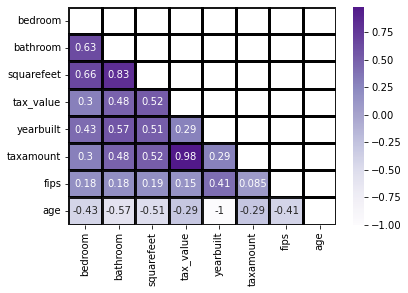

In [68]:
# pass my correlation matrix to Seaborn's heatmap 
kwargs = {'alpha':.9,
          'linewidth':3, 
          'linestyle':'-',
          'linecolor':'black'}

sns.heatmap(zillow_corr, cmap='Purples', annot=True, 
            mask=np.triu(zillow_corr), **kwargs)
plt.show()

The strongest correlation is tax_value and taxamount at 0.98
The strongest correlation is squarefeet vs bathrooms at 0.83

* Next strongest is  squarefeet vs bedrooms at 0.66
* Next  strongest is  bathroom vs bedroom at 0.63
* Others above 0.5:
        * yearbuild(age) vs bathrooms at 0.57
        * taxammount vs squarefeet at 0.52
        * year built(age) vs squarefeet at 0.51
        
The **target is tax_value** has a strong correlation with taxamount (0.98), and a correlation of (0.52) with squarefeet 
        

In [69]:
X = train[['bedroom', 'bathroom', 'squarefeet', 'yearbuilt',
       'taxamount','fips','age' ]]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,bedroom,1.755419
1,bathroom,2.773807
2,squarefeet,1.586225
3,yearbuilt,93532.369650
4,taxamount,1.412961
5,fips,1.113479
6,age,80.564610


In [70]:
X = train[['bedroom', 'bathroom', 'squarefeet' ,
       'taxamount','age' ]]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,bedroom,17.491667
1,bathroom,15.471204
2,squarefeet,4.446587
3,taxamount,2.105021
4,age,4.040794


In [77]:
X = train[[ 'squarefeet' ,
       'taxamount','age', 'bathroom']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,squarefeet,4.394186
1,taxamount,2.033588
2,age,2.543380
3,bathroom,6.386082


### might use these features for model since the combination had the most independence 
* 'squarefeet' ,'taxamount','bedroom'
* 'squarefeet' ,'taxamount','age'

### Maybe these features but there is a vif score above 5 in (bedroom/bathroom)
* 'squarefeet' , 'taxamount','age', 'bedroom'(7.22)
* 'squarefeet' , 'taxamount','age', 'bathroom'(6.38)

### 3.  Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [83]:
col = train.columns

In [84]:
col

Index(['bedroom', 'bathroom', 'squarefeet', 'tax_value', 'yearbuilt',
       'taxamount', 'fips', 'age'],
      dtype='object')

In [ ]:
def plot_variable_pair(df):
    col = train.columns
    for i , col,
    sns.lmplot(data=train, x=, y='final_grade',
           line_kws={'color':'red'})
    plt.show()

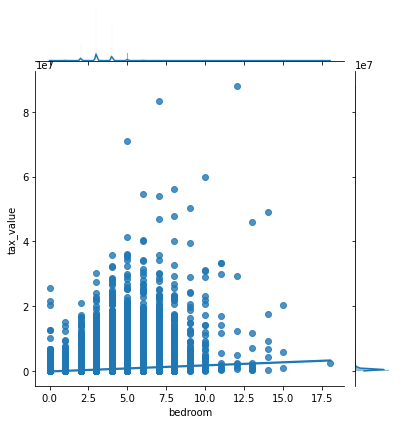

In [22]:
sns.jointplot(data=train, x='bedroom', y='tax_value', kind='reg')

Normal distribution, linear function has a positive slope close to 0.

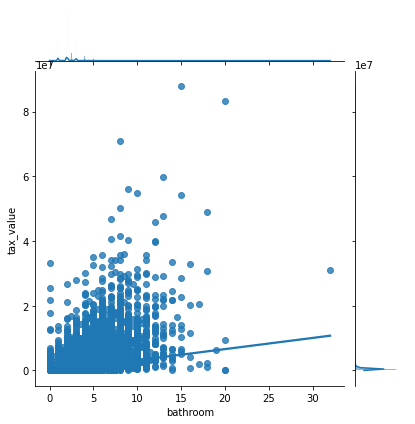

In [32]:
sns.jointplot(data=train, x='bathroom', y='tax_value', kind='reg')

normal distribution, slope is positive

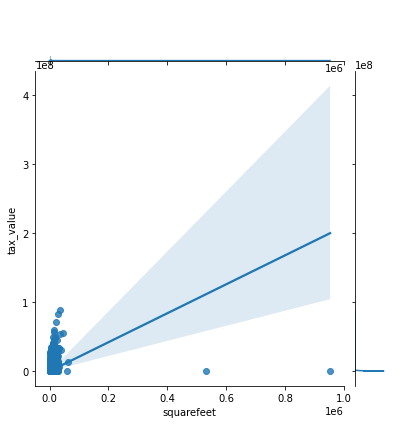

In [33]:
sns.jointplot(data=train, x='squarefeet', y='tax_value', kind='reg')

In [ ]:
Outliers are skewing the data here

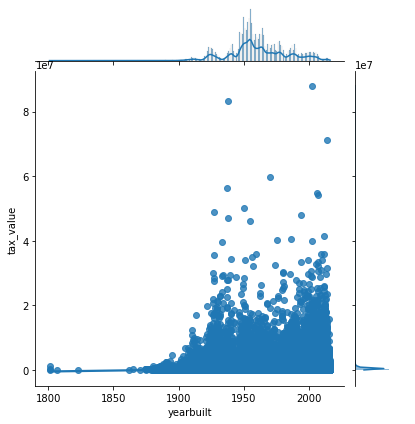

In [35]:
sns.jointplot(data=train, x='yearbuilt', y='tax_value', kind='reg')

line has a slope close to 0

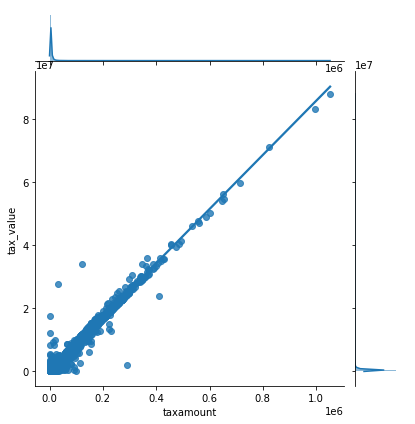

In [37]:
sns.jointplot(data=train, x='taxamount', y='tax_value', kind='reg')

Strong positive correlation, outliers are present but doent seem to skew at this axis scale

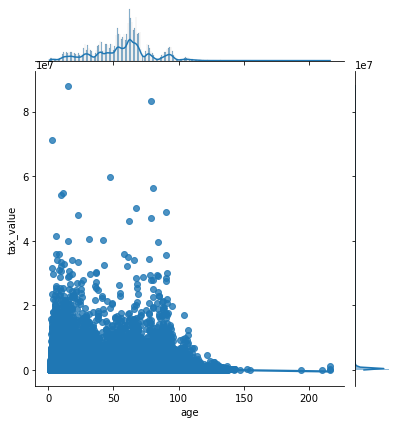

In [79]:
sns.jointplot(data=train, x='age', y='tax_value', kind='reg')

Slope is close to 0

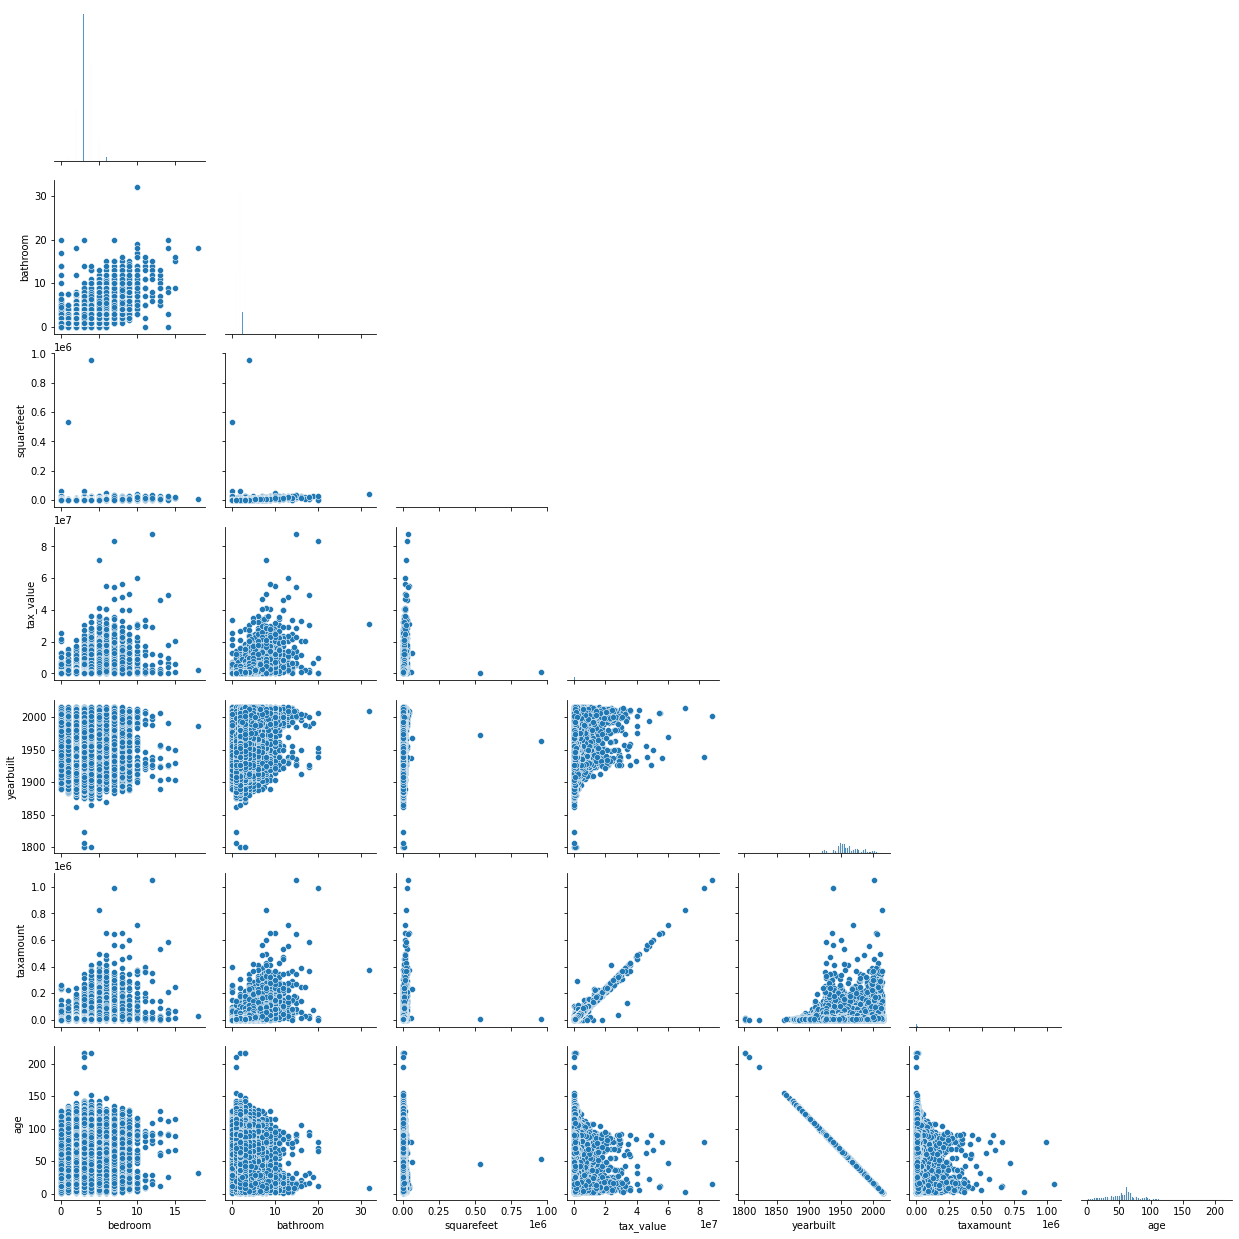

In [78]:
sns.pairplot(data=train.drop(columns='fips'),
            corner=True)
plt.show()